In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
!pip install deeptrack

# DeepTrack 2.1 - Generators

<!--<badge>--><a href="https://colab.research.google.com/github/softmatterlab/DeepTrack-2.0/blob/bm/improve-mie/examples/get-started/02. using_deeptrack_generators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

This tutorial introduces and explains generators.

### What are generators?

Generators are objects designed to help DeepTrack interface with other packages that want to retrieve the data. They achieve this by automatically executing your features and return data in a standardized format, such as in batches.

In [2]:
import deeptrack as dt
import matplotlib.pyplot as plt
import numpy as np
u = dt.units

## 1. Create a data pipeline

For demonstration purposes, we'll define a simple data pipeline.

<AxesSubplot:>

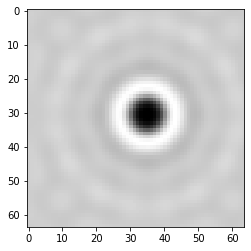

In [3]:
IMAGE_SIZE = 64
particle = dt.MieSphere(position=lambda: np.random.uniform(IMAGE_SIZE / 2 - 4, IMAGE_SIZE / 2 + 4, 2))
optics = dt.Brightfield(output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE))
image_pipeline = optics(particle)
image_pipeline.plot(cmap="gray")

In [4]:
label = image_pipeline >> (lambda image: image.get_property("position") - IMAGE_SIZE / 2)
data_pipeline = image_pipeline & label 

## 1. The ContinuousGenerator

The main generator used is the `ContinuousGenerator`. This will spin up a new thread in the background to continuously create more data asynchronously. This is very useful when training on the gpu, because it maximizes the utilization of both the gpu and the cpu! You create a generator like so:

In [5]:
generator = dt.generators.ContinuousGenerator(data_pipeline)

This will create images in batches for you asunchronously until it is filled up. Then it waits for a signal to replace that data with new data! Of course, you'll want to specify these parameters when creating the generator.

In [6]:
# A generator that will fill up with 128 samples, and output them in batches of 8.
generator = dt.generators.ContinuousGenerator(data_pipeline, batch_size=8, max_data_size=512)

In order to tell the generator to start creating data, we use the with statement:

In [7]:
with generator:
    print("Data is being created!")

Generating 108 / 80 samples before starting training
Data is being created!


However, as soon as you exit the `with` statement, you'll stop generating data. You can start it again by entering a new `with`-statement

In [8]:
import time
print(f"I have {len(generator)} batches ready for you!")
time.sleep(0.5)
print(f"I still have {len(generator)} batches ready for you!")
with generator:
    print(f"Working....")
    time.sleep(1)

print(f"I have {len(generator)} batches ready for you!")


I have 13 batches ready for you!
I still have 13 batches ready for you!
Generating 109 / 80 samples before starting training
Working....
I have 13 batches ready for you!


### 2.1 min_data_size

`min_data_size` describes how many samples the generator needs to create before it can be used. This is very useful for training, because you might not want to start your training untill you have enough data ready to not overfit.

In [9]:
# I'll create 10 samples before entering the with-statement
generator = dt.generators.ContinuousGenerator(data_pipeline, batch_size=8, min_data_size=10)

### 2.2 max_epochs_per_sample

Per default, during training, the generator will kepp using the same data until it has been replaced. If the pipeline is fast, this is not a problem. The model will likely see new data frequently. However, if the pipeline is slow, it's possible that each sample does not have time to be replaced fully between epochs. If a model is trained too many epochs on the same data, it may overfit. To mitigate this, we can use the `max_epochs_per_sample` option! This will flag how many times a data-point can be used before it has to be replaced!

In [10]:
# Data here is guaranteed to be fully replaced every two epochs of training
generator = dt.generators.ContinuousGenerator(data_pipeline, batch_size=8, max_epochs_per_sample=2)

### 2.2 label_function and batch_function

The continuous generator assumes you pipeline works as `data, label = pipeline.update()()`. Sometime this is inconvenient. In these cases you can define two functions that converts the output of the pipeline to the desired format.

In [11]:
generator = dt.generators.ContinuousGenerator(image_pipeline, label_function=lambda x: x.get_property("position"))

## 3. Training a model using a generator!

In [12]:
generator = dt.generators.ContinuousGenerator(
    data_pipeline, 
    batch_size=8, 
    min_data_size=128, 
    max_data_size=256,
    max_epochs_per_sample=2
)

model = dt.models.Convolutional(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1), number_of_outputs=2)

with generator:
    model.fit(generator, epochs=100)

Generating 166 / 128 samples before starting training
Epoch 1/100
20/20 [==============================] - 3s 5ms/step - loss: 2.0397
Epoch 2/100
20/20 [==============================] - 0s 5ms/step - loss: 1.9948
Epoch 3/100
20/20 [==============================] - 0s 5ms/step - loss: 1.9555
Epoch 4/100
20/20 [==============================] - 0s 16ms/step - loss: 1.9699
